# Analysis of the predictions made on Test Dataset

In [2]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json
from collections import defaultdict

results_dir = '../../results'

colors = ["#D62828", "#F77F00", "#003049", "#FCBF49", "#EAE2B7"]
#sns.set_palette(sns.set_palette(sns.color_palette(colors)))

plt.rcParams['font.size'] = 15
plt.rcParams['font.weight'] = 'medium'

In [9]:
def plot_precision_recall(evaluation_scores):
    print(evaluation_scores)
    fig, ax = plt.subplots(1, 1)
 
    sns.set_palette("dark")
    ax = sns.lineplot(data=evaluation_scores, y='Precision', x='Threshold', markers="o")
    ax = sns.lineplot(data=evaluation_scores, y='Recall', x='Threshold', markers="o")
    ax = sns.lineplot(data=evaluation_scores, y='Fscore', x='Threshold', markers="o")
    ax.xaxis.label.set_size(15)
    ax.yaxis.label.set_size(15)
    ax.legend(labels=["Precision", "Recall", "F1"])
    ax.set(xlabel='Threshold', ylabel='Precision/Recall/F1')
    ax.set(xlim=(0.0,1.0))
    ax.set(ylim=(0.0,1.0))
    
    plt.savefig(f'{results_dir}/precision_recall_over_threshold.pdf', transparent=True,
                       bbox_inches='tight')


def get_precision_recall(predictions, t):
    true_values = []
    pred_values = []
    precision, recall, fscore = 0, 0, 0
    
    for _,row in predictions.iterrows():
        true_values.append(int(row['p_buggy']))
        if row['predicted_p_buggy']>t:
            pred_values.append(1)
        else:
            pred_values.append(0)
    tp, fp, tn, fn = 0, 0, 0, 0
    for tv, pv in zip(true_values, pred_values):
        if tv == 1 == pv:
            tp+=1
        if tv == 0 and pv == 1:
            fp+=1
        if tv == 0 and pv == 0:
            tn+=1
        if tv == 1 and pv == 0:
            fn+=1
    if (tp+fp):
        precision = tp / (tp+fp)
    if (tp+fn):
        recall = tp / (tp+fn)
    if precision+recall:
        fscore = (2 * precision * recall) / (precision + recall)
    return precision, recall, fscore    

def get_precision_recall_different_threshold(predictions):
    p, r, f = [], [], []
    thresholds = np.arange(0.1,1.0,0.1)
   
    for t in thresholds:
        pr, rc, fs = get_precision_recall(predictions, t)
        p.append(pr)
        r.append(rc)
        f.append(fs)
    
    return thresholds, p,r,f

In [10]:
def output_as_json_for_manual_inspection(predictions, file_name):
    predictions_known_non_buggy = predictions[predictions['p_buggy'] == 0]
    # Only output the warnings for known non-buggy
    json_vals = []
    for i, v in predictions_known_non_buggy.iterrows():
        try:
            val = v.to_dict()
            # val['name_types'] = list(val['name_types'])
            if val['predicted_p_buggy']>0.5:
                json_vals.append(val)
        except Exception as e:
            # print(e)
            pass
    out_file = f'{results_dir}/prediction_results/{file_name}_warnings.json'
    print(f'Writing to file {out_file} for manual inspection using web-page')
    
    with open(out_file, 'w') as f:
        json.dump(json_vals, f)

In [11]:
def read_dataset_get_eval_scores(test_prediction_file_name):
    test_dataset_predictions = pd.read_pickle(filepath_or_buffer=f'{results_dir}/prediction_results/{test_prediction_file_name}.pkl', compression='gzip')
    # print(test_dataset_predictions)
    print("Finished Reading, finding evaluation scores")
    thresholds, pr, rcl, fscr = get_precision_recall_different_threshold(predictions=test_dataset_predictions)
    evaluation_results = {
        'Threshold':thresholds,
        'Precision': pr,
        'Recall': rcl,
        'Fscore': fscr
    }
    default_threshold_index = list(evaluation_results['Threshold']).index(0.5)
    print(f'F1 Score on the test dataset for the default threshold 0.5 is --> {evaluation_results["Fscore"][default_threshold_index]}')
    other_threshold_index = list(evaluation_results['Threshold']).index(0.4)
    print(f'Precision on the test dataset for threshold 0.4 is --> {evaluation_results["Precision"][other_threshold_index]}')
    print(f'Recall on the test dataset for threshold 0.4 is --> {evaluation_results["Recall"][other_threshold_index]}')
    print(f'F1 Score on the test dataset for threshold 0.4 is --> {evaluation_results["Fscore"][other_threshold_index]}')
    return test_dataset_predictions, evaluation_results

In [12]:
def run(test_prediction_file_name, text):
    test_dataset_predictions, evaluation_results = read_dataset_get_eval_scores(test_prediction_file_name)
    output_as_json_for_manual_inspection(test_dataset_predictions, test_prediction_file_name)
    evaluation_results['expriment_type'] = [text]*len(evaluation_results['Threshold'])
    #   res = pd.DataFrame(evaluation_results)
    plot_precision_recall(evaluation_results)

Finished Reading, finding evaluation scores
F1 Score on the test dataset for the default threshold 0.5 is --> 0.8787700219638934
Precision on the test dataset for threshold 0.4 is --> 0.8791198138813494
Recall on the test dataset for threshold 0.4 is --> 0.9069
F1 Score on the test dataset for threshold 0.4 is --> 0.8927938570584761
Writing to file ../../results/prediction_results/test_dataset_all_types_predictions_warnings.json for manual inspection using web-page
{'Threshold': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]), 'Precision': [0.6251803525500282, 0.6985747713252499, 0.7744270205066345, 0.8791198138813494, 0.9463482173762547, 0.9694477085781433, 0.982918789331735, 0.990549215406562, 0.9951071761416589], 'Recall': [0.9966, 0.9852, 0.963, 0.9069, 0.8202, 0.7425, 0.656, 0.5555, 0.4271], 'Fscore': [0.7683589684283566, 0.8174915985561962, 0.8584800534878538, 0.8927938570584761, 0.8787700219638934, 0.8409309700436038, 0.7868537843348927, 0.7118144541260891, 0.59767702211027

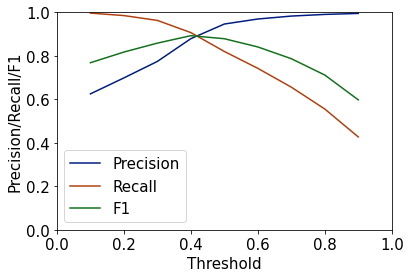

In [13]:
run('test_dataset_all_types_predictions', 'All Types')

# Inspection and Heuristic Filtering of Warnings

In [8]:
def print_warnings(warnings, subset, label):
    print(f"\n{label}:")
    fps = warnings[warnings.index.isin(subset)]
    print(fps[["var", "value", "type", "predicted_p_buggy"]][0:40])

In [9]:
def count_tps_fps(warnings, known_tps, known_fps):
    tps = set(warnings.index).intersection(known_tps)
    fps = set(warnings.index).intersection(known_fps)
    
    print(f"{len(warnings)} warnings, {len(tps)} known true positives, {len(fps)} known false positives")
    print(f"Unclassified: {sorted(set(warnings.index).difference(tps.union(fps)))}")

In [10]:
def type_is_name(w):
    return "str" in w["var"].lower() and w["type"] == "str"

def generic_name(w):
    for n in ["data", "value", "result", "temp", "tmp", "sample"]:
        if n in w["var"]:
            return True
    return False

def short_name(w):
    for sub in w["var"].split("_"):
        if len(sub) <= 2:
#             print(f"Removing {w['var']}")
            return True
    return False

def heuristically_remove_meaningless_names(warnings):
    warnings = warnings[warnings.apply(lambda w: not type_is_name(w), axis=1)]
    print(f"Warnings after str heuristic: {len(warnings)}")
    warnings = warnings[warnings.apply(lambda w: not generic_name(w), axis=1)]
    print(f"Warnings after generic name heuristics {len(warnings)}")
    warnings = warnings[warnings.apply(lambda w: not short_name(w), axis=1)]
    print(f"Warnings after short name heuristics {len(warnings)}")
    
    return warnings

In [11]:
def to_json_for_survey(predictions, file_name):
    json_vals = []
    for i, v in predictions.iterrows():
        example = {
            "name": v["var"],
            "value": v["value"],
            "type": v["type"]
        }
        json_vals.append(example)
    out_file = f'{results_dir}/survey_{file_name}.json'
    with open(out_file, 'w') as f:
        json.dump(json_vals, f, indent=4)

In [12]:
test_prediction_file_name = 'test_dataset_all_types_predictions'
predictions = pd.read_pickle(filepath_or_buffer=f'{results_dir}/prediction_results/{test_prediction_file_name}.pkl', compression='gzip')

warnings = predictions[predictions['p_buggy'] == 0]
warnings = warnings[warnings['predicted_p_buggy'] > 0.8]
warnings = heuristically_remove_meaningless_names(warnings)
to_json_for_survey(warnings, "warnings")

originals = predictions[predictions['p_buggy'] == 0]
originals = originals[originals['predicted_p_buggy'] <= 0.8]
originals = heuristically_remove_meaningless_names(originals)
to_json_for_survey(originals, "originals")

Warnings after str heuristic: 50
Warnings after generic name heuristics 42
Warnings after short name heuristics 35
Warnings after str heuristic: 9834
Warnings after generic name heuristics 8969
Warnings after short name heuristics 7179


In [14]:
# all types with type-guided negative examples
test_prediction_file_name = 'test_dataset_all_types_predictions'
known_tps = [2487, 2527, 3150, 3197, 3227, 3329, 3607, 3715, 3754,
                       4201, 4207, 4241, 4376, 4792, 4800, 4902, 4977, 5050,
                       5055, 5069, 5075, 5340, 5355, 5500, 5506, 5512, 5519,
                       5589, 5595, 5706, 5729, 5805, 5874, 5875, 5927, 5939,
                       6058, 6089, 6110, 6182, 6211, 6282, 6498, 6568, 6597]
known_tps_incorrect_value = [4207, 4902]
known_fps = [1995, 2772, 2935, 3157, 3493, 3510, 3674, 4165, 4282,
                       4719, 4831, 4903, 4950, 5120, 5077, 4988, 5141, 5149,
                       5157, 5531, 5564, 5594, 5665, 5677, 5755, 5792, 5849,
                       5897, 5982, 5989, 6026, 6037, 6101, 6147, 6189, 6241,
                       6276, 6292, 6314, 6340, 6376, 6391, 6500, 6538, 6549,
                       6573, 6580, 6590, 6654]

# all types with random negative examples
# test_prediction_file_name = 'test_dataset_all_types_predictions_random_neg_generation'
# known_tps = []
# known_fps = []

warnings = pd.read_pickle(filepath_or_buffer=f'{results_dir}/prediction_results/{test_prediction_file_name}.pkl', compression='gzip')
examples_with_shape = warnings[warnings.apply(lambda w: w["size"] != -1, axis=1)]
warnings = warnings[warnings['p_buggy'] == 0]
warnings = warnings[warnings['predicted_p_buggy'] > 0.5]
# print(f"Warnings before pruning: {len(warnings)}")
warnings = heuristically_remove_meaningless_names(warnings)
# print(warnings[:30])
examples_with_shape
# print(warnings[["var", "value", "type", "predicted_p_buggy"]][60:80])
# print_warnings(warnings[:30], known_fps, "False positives")
# print_warnings(warnings[:30], known_tps, "True positives")
# count_tps_fps(warnings[:30], known_tps, known_fps)

Warnings after str heuristic: 455
Warnings after generic name heuristics 420
Warnings after short name heuristics 339


,file,var,value,line,type,len,size,p_buggy,orig_type,predicted_p_buggy
2,nb_355571,temp,"{'data': array([[5.1, 3.5, 1.4, 0.2],\n ...",116,Bunch,7,"(5,)",1.0,ndarray,1.000000
3,nb_1244226,ones_x,/home,81,str,5,"(1000,)",1.0,ndarray,1.000000
4,nb_471700,result,"{'data': array([[5.1, 3.5, 1.4, 0.2],\n ...",64,Bunch,7,(),1.0,float64,0.999999
5,nb_999610,pct_increase,"{'data': array([[5.1, 3.5, 1.4, 0.2],\n ...",87,Bunch,7,(),1.0,float64,0.999999
6,nb_560347,bins,"{'data': array([[5.1, 3.5, 1.4, 0.2],\n ...",139,Bunch,7,"(51,)",1.0,ndarray,0.999999
...,...,...,...,...,...,...,...,...,...,...
19892,nb_648388,y_train,[4 7 1 3 3 9 8 1 9 2],19,ndarray,1149,"(1149,)",0.0,ndarray,0.000133
19895,nb_1020393,y_train,[4 7 0 6 4 6 6 4 1 7],42,ndarray,1347,"(1347,)",0.0,ndarray,0.000130
19951,nb_254350,y_train,[6 0 0 3 0 5 0 0 4 1],21,ndarray,1437,"(1437,)",0.0,ndarray,0.000116
19956,nb_1114008,X_test,[[7.88600e-02 8.00000e+01 4.95000e+00 0.00000e...,36,ndarray,106,"(106, 13)",0.0,ndarray,0.000107


# Statistics about Dataset

In [15]:
pos_examples = pd.read_pickle(filepath_or_buffer=f'{results_dir}/positive_examples.pkl', compression='gzip')
test_dataset = pd.read_pickle(filepath_or_buffer=f'{results_dir}/test_examples.pkl', compression='gzip')
files = set(pos_examples["file"].tolist())
files = files.union(set(test_dataset["file"].tolist()))
print(f"Number of files with extracted pairs: {len(files)}")
with open(f"{results_dir}/files_with_pairs.txt", "w") as fp:
    for f in files:
        fp.write(f"{f}\n")

Number of files with extracted pairs: 107278
